In [1]:
from wrapper_functions import *

2022-10-19 23:56:54.419111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which is considered *experimental*."
/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/gpflow/experimental/utils.py:43: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  f"You're calling {name} which i

TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


2022-10-19 23:57:15.212958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Experiment II: 2D Spatial Field

### Model Configs

In [2]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=10 # @param
mcmc_burnin=2_500 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


In [3]:
# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = .75 # @param
bma_gp_l2_regularizer = 0.1 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


In [4]:
# BNE parameters.
bne_gp_lengthscale = 4 # 5. # @param
bne_gp_l2_regularizer = 5 # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param

In [5]:
# bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
#                 gp_l2_regularizer=bma_gp_l2_regularizer,
#                 y_noise_std=y_noise_std,
#                 map_step_size=map_step_size,
#                 map_num_steps=map_num_steps,
#                 mcmc_step_size=mcmc_step_size,
#                 mcmc_num_steps=mcmc_num_steps,
#                 mcmc_initialize_from_map=False,
#                 #return_weight_samples=True,
#                 n_samples_eval=bma_n_samples_eval,
#                 n_samples_train=bma_n_samples_train,
#                 n_samples_test=bma_n_samples_test,
#                 seed=bma_seed)


# bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
#                   gp_l2_regularizer=bne_gp_l2_regularizer,
#                   variance_prior_mean=bne_variance_prior_mean,
#                   skewness_prior_mean=bne_skewness_prior_mean,
#                   map_step_size=map_step_size,
#                   map_num_steps=map_num_steps,
#                   mcmc_step_size=mcmc_step_size,
#                   mcmc_num_steps=mcmc_num_steps,
#                   mcmc_nchain=mcmc_nchain,
#                   mcmc_burnin=mcmc_burnin,
#                   mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
#                   seed=bne_seed)

### Read training/prediction data

In [5]:
training_eastMA = pd.read_csv('./data/training_dataset/training_eastMA.csv')
training_eastMA_noMI = training_eastMA[:51]
training_eastMA_folds = pd.read_csv('./data/training_dataset/training_eastMA_folds.csv')
base_model_predictions_eastMA = pd.read_csv('./data/prediction_dataset/base_model_predictions_eastMA.csv')
display(training_eastMA.shape, training_eastMA_folds.shape, base_model_predictions_eastMA.shape)
print("pred longitude max and min", base_model_predictions_eastMA["lon"].max(),base_model_predictions_eastMA["lon"].min())
print("pred latitude max and min", base_model_predictions_eastMA["lat"].max(),base_model_predictions_eastMA["lat"].min())
#list(base_model_predictions_eastMA.columns)
print("train longitude max and min", training_eastMA["lon"].max(),training_eastMA["lon"].min())
print("train latitude max and min", training_eastMA["lat"].max(),training_eastMA["lat"].min())

(55, 7)

(55, 10)

(84421, 5)

pred longitude max and min -69.93 -73.5
pred latitude max and min 44.3 40.6
train longitude max and min -70.023598 -73.443056
train latitude max and min 44.107524 40.74529


In [6]:
# standardize
X_train1 = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
X_test1 = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
X_valid = np.concatenate((X_train1, X_test1), axis=0)
X_centr = np.mean(X_valid, axis=0)
X_scale = np.max(X_valid, axis=0) - np.min(X_valid, axis=0)

X_train1 = (X_train1 - X_centr) / X_scale
X_test1 = (X_test1 - X_centr) / X_scale

Y_train = np.expand_dims(training_eastMA_noMI["aqs"], 1).astype(np.float32)
#Y_test = np.expand_dims(base_model_predictions_eastMA["pred_av"], 1).astype(np.float32)

print("2011 center and scale: ", X_centr, X_scale)

2011 center and scale:  [-72.185104  42.680347] [3.5699997 3.7000008]


In [7]:
base_model_names = ["pred_av", "pred_gs", "pred_caces"]
base_preds_train = tf.stack([training_eastMA_noMI[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
base_preds_test = tf.stack([base_model_predictions_eastMA[base_model_name].astype(np.float32) for base_model_name in base_model_names], axis=-1)
#base_preds_test
display(base_preds_train.shape, base_preds_test.shape)

TensorShape([51, 3])

TensorShape([84421, 3])

## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$




In [8]:
# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=bma_gp_lengthscale,
                             l2_regularizer=bma_gp_l2_regularizer,
                             y_noise_std=y_noise_std))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

In [9]:
display(bma_model_config, map_config, mcmc_config)

{'lengthscale': 0.75,
 'l2_regularizer': 0.1,
 'hidden_units': 1024,
 'y_noise_std': 0.01}

{'learning_rate': 0.0005, 'num_steps': 10000}

{'step_size': 0.0001,
 'num_steps': 1000,
 'burnin': 2500,
 'nchain': 10,
 'seed': 0}

### Build model

In [10]:
bma_prior, bma_gp_config = bma_dist(X_train1, 
                                    base_preds_train, 
                                    **bma_model_config)

bma_model_config.update(bma_gp_config)

# Check if the model graph is specified correctly.
bma_prior.resolve_graph()

/Users/liyanran/opt/anaconda3/envs/BNE/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer OrthogonalRandomFeatures is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


(('gp_weights', ()), ('y', ('gp_weights',)))

In [11]:
def run_posterior_inference(model_dist: tfd.Distribution, 
                            Y: tf.Tensor, 
                            mcmc_config: Dict[str, Any], 
                            map_config: Optional[Dict[str, Any]] = None, 
                            model_config: Optional[Dict[str, Any]] = None,
                            initialize_from_map: bool = True):
  """Wrapper function for running MCMC with MAP initialization."""
  # Defines posterior log likelihood function, and also a 
  # randomly-sampled initial state from model prior.
  nchain = mcmc_config['nchain']
  init_state, target_log_prob_fn = prepare_mcmc(model_dist, Y, nchain=nchain)  
  
  if initialize_from_map:
    # Initializes at MAP, shape (num_chains, param_shape_0, param_shape_1).
    print('Running MAP:', end='\t')
    init_state = run_map(target_log_prob_fn=target_log_prob_fn, 
                         gp_config=model_config,
                         **map_config)

    init_state = tf.stack([init_state] * mcmc_nchain, axis=0)

  # Run MCMC, shape (param_shape_0, param_shape_1, num_chains).
  print('Running MCMC:', end='\t')
  gp_w_samples, chain_samples, sampler_stat = run_mcmc(init_state=init_state,
                             target_log_prob_fn=target_log_prob_fn,
                             debug_mode=True,
                             **mcmc_config)  
  
  return gp_w_samples, chain_samples, sampler_stat

In [12]:
display(bma_model_config, map_config,mcmc_config, bma_prior)

{'lengthscale': 0.75,
 'l2_regularizer': 0.1,
 'hidden_units': 1024,
 'y_noise_std': 0.01,
 'units': 3,
 'seed': 0}

{'learning_rate': 0.0005, 'num_steps': 10000}

{'step_size': 0.0001,
 'num_steps': 1000,
 'burnin': 2500,
 'nchain': 10,
 'seed': 0}

<tfp.distributions.JointDistributionNamedAutoBatched 'JointDistributionNamedAutoBatched' batch_shape=[] event_shape={gp_weights: [1024, 3], y: [51, 1]} dtype={gp_weights: float32, y: float32}>

### Run MCMC

In [13]:
bma_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_train, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)


bma_joint_samples = make_bma_samples(X_test1, None, base_preds_test, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config,
                                     n_samples=bma_n_samples_eval, 
                                     seed=bne_seed,
                                     y_samples_only=False)



Running MAP:	398514.625...216403.21875...210974.21875...207842.171875...205643.984375...202065.21875...196435.96875...190838.125...186203.75...182792.703125...Done.
Running MCMC:	Acceptance Ratio: 0.6589220762252808


In [70]:
bma_joint_samples['y']
#np.mean((means_pred - means_true)**2) / np.var(means_true)
mse_all = tf.reduce_mean((means_train_mcmc-Y_train_mcmc)** 2)/ np.var(Y_train_mcmc)
mse_all
bma_joint_samples

<tf.Tensor: shape=(250, 84421, 1), dtype=float32, numpy=
array([[[10.377769 ],
        [10.385187 ],
        [10.386557 ],
        ...,
        [       nan],
        [       nan],
        [ 6.384716 ]],

       [[ 9.403046 ],
        [ 9.397229 ],
        [ 9.196226 ],
        ...,
        [       nan],
        [       nan],
        [ 6.5076895]],

       [[10.362035 ],
        [10.365438 ],
        [10.370351 ],
        ...,
        [       nan],
        [       nan],
        [ 7.639178 ]],

       ...,

       [[10.376601 ],
        [10.378027 ],
        [10.370573 ],
        ...,
        [       nan],
        [       nan],
        [ 5.7540393]],

       [[ 9.393609 ],
        [ 9.395815 ],
        [ 9.313379 ],
        ...,
        [       nan],
        [       nan],
        [ 8.333944 ]],

       [[ 9.393304 ],
        [ 9.399228 ],
        [ 9.202443 ],
        ...,
        [       nan],
        [       nan],
        [ 6.5123954]]], dtype=float32)>

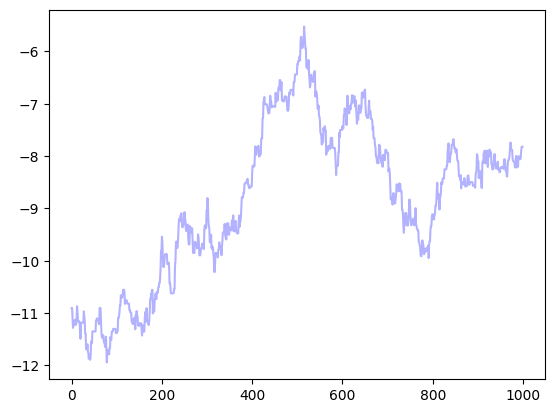

In [14]:
plt.plot(chain_samples[:, 8, 111, 1], c='b', alpha=.3)
# plt.title('Traceplot')
# plt.plot(bma_gp_w_samples[1][:,9, 127, 1].numpy(), 'b')
# plt.xlabel('Iteration')
# plt.ylabel('Position')
plt.show()

In [19]:
#np.mean((means_pred - means_true)**2) / np.var(means_true)
# mse = tf.reduce_mean((means_train_mcmc-Y_train_mcmc)** 2)/ np.var(Y_train_mcmc)
# mse
def rmse(y_obs, y_pred):
    return np.sqrt(np.mean((y_obs - y_pred) ** 2))
bma_mcmc_rmse = rmse(means_train_mcmc, Y_train_mcmc)

reg = LinearRegression().fit(X_train1, Y_train)
y_pred = reg.predict(X_train1)
rmse_lr = mean_squared_error(y_true=Y_train, y_pred=y_pred, squared=False)
display(rmse_lr, bma_mcmc_rmse)

1.6748887

1.1692442

In [90]:
mean_squared_error(y_true=Y_train_mcmc, y_pred=means_train_mcmc, squared=True)
#bma_mcmc_rmse = mean_squared_error(y_true=Y_train_mcmc, y_pred=means_train_mcmc, squared=False)



2.0773873

In [98]:
np.mean((means_train_mcmc - Y_train_mcmc)** 2)

2.0773873

In [18]:
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [35]:
# Compute sample stats.
sample_mean = tf.reduce_mean(means_train_mcmc, axis=[0, 1])
# ==> approx equal to weights

sample_var = tf.reduce_mean(
    tf.math.squared_difference(chain_samples, sample_mean),
    axis=[0, 1])
# ==> less than 1

# def rmse(y_obs, y_pred):
#     """Computes root mean square error."""
#     return np.sqrt(np.mean((y_obs.squeeze() - y_pred.squeeze()) ** 2))
# rmse(Y_train_mcmc, means_train_mcmc)

samples = samples[:num_sample]
means_pred = np.mean(samples, axis=0)
stds_pred = np.std(samples, axis=0)
mse_ind = np.mean(
    (means_pred[ind_ids] - means_true[ind_ids])**2) / np.var(means_true[ind_ids])

### Prepare Data for BAE/BNE

In [16]:
# Construct data from BMA samples, shapes (num_samples * num_data, ...)
means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
    X_train1, Y_train, base_preds_train, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_train,
    seed=bma_seed, 
    prepare_mcmc_training=True)

# Mean samples based on test data, shape (num_samples, num_data, num_output).
# It is used to generate final examples in `make_bne_samples()`.
means_test_mcmc = make_bma_samples(
    X_test1, None, base_preds_test, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_test,
    seed=bma_seed)

In [48]:
display(means_train_mcmc.shape, X_train_mcmc.shape, Y_train_mcmc.shape, means_test_mcmc.shape)

TensorShape([5100, 1])

TensorShape([5100, 2])

TensorShape([5100, 1])

TensorShape([250, 84421, 1])

## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

In [49]:
# # # BNE GP Configs.
# # lengthscale = 1. # @param
# # l2_regularizer = 10. # @param

# BNE model configs. 
# If estimate_mean=False, only estimates a constant variance on top of the 
# original model.
estimate_mean = "True" # @param ["True", "False"]
variance_prior_mean=0. # @param
# # MAP and MCMC configs
# map_step_size=0.1 # @param
# map_num_steps=10_000 # @param

# mcmc_step_size=1e-2 # @param
# mcmc_num_steps=10_000 # @param

bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=bne_gp_lengthscale, 
                          l2_regularizer=bne_gp_l2_regularizer))
bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps,
                       burnin=mcmc_burnin,
                       nchain=mcmc_nchain))

### Build Model

In [50]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))


In [51]:
display(bne_prior, bne_model_config, map_config, mcmc_config)

<tfp.distributions.JointDistributionNamedAutoBatched 'JointDistributionNamedAutoBatched' batch_shape=[] event_shape={gp_weights: [128, 2], y: [5100, 1]} dtype={gp_weights: float32, y: float32}>

{'estimate_mean': True,
 'estimate_variance': False,
 'estimate_skewness': False,
 'variance_prior_mean': 0.0,
 'skewness_prior_mean': 0.0,
 'lengthscale': 4,
 'l2_regularizer': 5,
 'hidden_units': 128,
 'y_noise_std': -1.0,
 'units': 2,
 'seed': 0}

{'learning_rate': 0.0005, 'num_steps': 10000}

{'step_size': 0.0001,
 'num_steps': 1000,
 'burnin': 2500,
 'nchain': 10,
 'seed': 0}

### Run MCMC

In [53]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples, chain_samples, sampler_stat = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

Running MAP:	8040.71630859375...7257.259765625...7244.951171875...7239.53125...7238.07568359375...7237.91650390625...7237.91259765625...7237.912109375...7237.912109375...7237.912109375...Done.
Running MCMC:	Acceptance Ratio: 0.7726417183876038


In [20]:
surface_pred_bae = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bae = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}

# dealing with NA

In [21]:
# percentile of NAN
np.sum(np.isnan(np.mean(bne_joint_samples['mean_original'], axis=0)))/84421

0.005235664112010045

## Bayesian Nonparametric Ensemble (Variance Only)
So far, we are only estimating the mean-component of the model, i.e., we are assuming: 

$y \sim Gaussian(m(x), \sigma^2); \quad m(x) = GP(0, k)$.

By doing so, the model is implicitly assuming the distribution of $y$ is always a symmetric Gaussian distribution with constant mean across space and time. As a result, our model can only quantify model uncertainty (due to lack of data) via the GP prior, but cannot flexibly capture the data uncertainty that is inherent to the empirical distribution of y.

To resolve this, we extend the ensemble's outcome distribution $y | f$ by also estimating the higher moments of the data distribution (e.g., variance, skewness, etc) using flexible estimators. Specifically, we specify the outcome distribution family to the [maximum-entropy distribution](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) given the known moments, so the predictive distribution is [minimax](https://arxiv.org/pdf/math/0410076.pdf) and still statistically efficient to estimate.

For example, when we want to estimate the first two moments (mean and variance) of the distribution, this leads to a Gaussian distribution with spatio-temporally adaptive variance $\sigma(x)^2$:

$$y \sim Gaussian(m(x), \sigma(x)^2); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma)$$

and when we want to estimate the first three moments (mean and variance) of the distribution, this leads to a [Exponentially-modifed Gaussian](https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution) (EMG) distribution with spatio-temporally adaptive variance $\sigma(x)^2$ and skewness $\lambda(x)$:

$$y \sim EMG(m(x), \sigma(x)^2, \lambda(x)); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma), \lambda \sim GP(0, k_\lambda)$$




### Define Model & Run MCMC

In [22]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))
Running MAP:	7446.732421875...7053.1435546875...7051.3798828125...7051.36865234375...7051.36865234375...7051.36865234375...7051.36865234375...7051.36865234375...7051.36865234375...7051.36865234375...Done.
Running MCMC:	Acceptance Ratio: 0.6818126440048218


In [23]:
surface_pred_bne_vo = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bne_vo = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}



## Bayesian Nonparametric Ensemble (Variance + Skewness)

### Define Model & Run MCMC

In [24]:
# Construct prior distribution.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test1,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))
Running MAP:	7174.9990234375...7055.798828125...7053.3818359375...7053.35888671875...7053.3583984375...7053.35888671875...7053.35791015625...7053.35791015625...7053.35791015625...7053.3583984375...Done.
Running MCMC:	Acceptance Ratio: 0.7549411058425903


In [25]:
surface_pred_bne_vs = {k: np.mean(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}
surface_var_bne_vs = {k: np.var(np.nan_to_num(bne_joint_samples[k]), axis=0) for k in ('y', 'mean_original', 'resid')}

## Basic Plots

In [26]:
#_DATA_ADDR_PREFIX = "./example/data"
# Tuning Parameters
BMA_lenthscale = bma_gp_lengthscale
BNE_lenthscale = bne_gp_lengthscale
BMA_L2 = bma_gp_l2_regularizer
BNE_L2 = bne_gp_l2_regularizer
_SAVE_ADDR_PREFIX = "./pic/BMA_lenthscale_{}_L2_{}_BNE_lenthscale_{}_L2_{}".format(BMA_lenthscale, BMA_L2, BNE_lenthscale, BNE_L2)

path=_SAVE_ADDR_PREFIX
isExists=os.path.exists(path) #判断路径是否存在，存在则返回true

if not isExists:
    os.makedirs(path)


### 1. The predictive surface of individual base models.

In [27]:
coordinate = np.asarray(base_model_predictions_eastMA[["lon", "lat"]].values.tolist()).astype(np.float32)
monitors = np.asarray(training_eastMA_noMI[["lon", "lat"]].values.tolist()).astype(np.float32)
base_model_names = ["pred_av", "pred_gs", "pred_caces"]

base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]] = np.where(np.isnan(base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]]), 0, base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]])
color_norm_base = make_color_norm(
    base_model_predictions_eastMA[["pred_av", "pred_gs", "pred_caces"]],   
    method="percentile")

for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'base_model_{}_bmals_{}_r_{}_bnels_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                 bne_gp_lengthscale, bne_gp_l2_regularizer))
    
    posterior_heatmap_2d(base_model_predictions_eastMA[base_model_name], coordinate,
                         monitors,
                         cmap='RdYlGn_r',
                         norm=color_norm_base, 
                         #norm_method="percentile",
                         save_addr=save_name)

### 2. The predictive surface of individual BNE gp weights

In [28]:
bma_ensemble_weights = bma_joint_samples['ensemble_weights']
ensemble_weights_val = tf.reduce_mean(bma_ensemble_weights, axis=0)

weights_dict = {
    "AV": ensemble_weights_val[:, 0],
    "GS": ensemble_weights_val[:,1],
    "CACES": ensemble_weights_val[:,2],
}
#weights_dict
color_norm_weights = make_color_norm(
    list(weights_dict.values()),#[2],   
    method="percentile")

In [29]:
ensemble_weights_var = np.var(bma_ensemble_weights, axis=0)
weights_var_dict = {
    "AV": ensemble_weights_var[:, 0],
    "GS": ensemble_weights_var[:,1],
    "CACES": ensemble_weights_var[:,2],
}
#weights_dict
color_norm_weights_var = make_color_norm(
    list(weights_var_dict.values()),#[0],   
    method="percentile")
# display(ensemble_weights_val,ensemble_weights_var)

In [30]:
base_model_names = ["AV", "GS", "CACES"]
for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'base_weights_{}_bmals_{}_r_{}_bnels_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                 bne_gp_lengthscale, bne_gp_l2_regularizer))
    
    posterior_heatmap_2d(weights_dict[base_model_name], coordinate,
                         monitors,
                         cmap='viridis',
                         norm=color_norm_weights, 
                         #norm_method="percentile",
                         #save_addr='')
                         save_addr=save_name)

In [31]:
# plot weights' variance
for base_model_name in base_model_names:
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                             'base_wvar_{}_bmals_{}_r_{}_bnels_{}_r_{}.png'.format(
                                 base_model_name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                 bne_gp_lengthscale, bne_gp_l2_regularizer))
    
    posterior_heatmap_2d(weights_var_dict[base_model_name], coordinate,
                         monitors,
                         cmap='viridis',
                         norm=color_norm_weights_var, 
                         #norm_method="percentile",
                         #save_addr='')
                         save_addr=save_name)

### 3. The predictive surface of Y_mean, residual process, and Y_mean + residual process.

In [32]:
# BAE
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bae.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bae.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bae.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'BAE_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                    #norm_method="percentile",
                    #save_addr='')
                    save_addr=save_name)
    

In [33]:
# BNE vo
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bne_vo.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bne_vo.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bne_vo.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'BNEvo_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                                      save_addr=save_name)
                    #norm_method="percentile",
                    #save_addr='')
    

In [34]:
# BNE v+s
color_norm_pred = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[:2][0]),
    list(surface_pred_bne_vs.values())[:2],  
    method="percentile")

color_norm_pred_r = make_color_norm(
    #np.nan_to_num(list(surface_pred_bae.values())[2:]),
    list(surface_pred_bne_vs.values())[2],  
    method="residual_percentile")


for name, value in surface_pred_bne_vs.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'BNEvs_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(name, bma_gp_lengthscale, 
                                bma_gp_l2_regularizer, bne_gp_lengthscale, bne_gp_l2_regularizer))

    value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                                  cmap='RdYlGn_r',
                    norm= color_norm_pred_r if name=='resid' else color_norm_pred,
                    #norm_method="percentile",
                    #save_addr='')
                save_addr=save_name)
    

### 4.The predictive variance of Y_mean, residual process, and Y.

In [35]:
# BAE
color_norm_var = make_color_norm(
    list(surface_var_bae.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bae.values())[2], 
    method="percentile")


for name, value in surface_var_bae.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'var_BAE_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr=save_name)

In [36]:
# BNE vo
color_norm_var = make_color_norm(
    list(surface_var_bne_vo.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bne_vo.values())[2], 
    method="percentile")


for name, value in surface_var_bne_vo.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'var_BNEvo_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr=save_name)

In [37]:
# BNE v+s
color_norm_var = make_color_norm(
    list(surface_var_bne_vs.values())[:2], 
    method="percentile")

color_norm_var_r = make_color_norm(
    list(surface_var_bne_vs.values())[2], 
    method="percentile")


for name, value in surface_var_bne_vs.items():
    save_name = os.path.join(_SAVE_ADDR_PREFIX,
                            'var_BNEvs_{}_bma:ls_{}_r_{}_bne:ls_{}_r_{}.png'.format(
                                name, bma_gp_lengthscale,  bma_gp_l2_regularizer,
                                bne_gp_lengthscale, bne_gp_l2_regularizer))
    #value = np.where(np.isnan(value), 0, value)
    color_norm = posterior_heatmap_2d(value, X=coordinate, X_monitor=monitors,
                                cmap='inferno_r',
                                norm= color_norm_var_r if name=='resid' else color_norm_var,
                                #norm_method="percentile",
                                save_addr=save_name)

### Evaluation

In [38]:
# base_preds_train, base_preds_test, kernel_names = run_base_models(
#       X_train1, X_train1, X_test1, Y_train, Y_train, Y_test, num_train_steps=100, debug_mode=False)

# d0 = dict(X_base=X_train1,
#                    X_train=X_train1,
#                    X_test=X_test1,
#                    Y_base=Y_train, 
#                    Y_train=Y_train, 
#                    Y_test=Y_test, 
#                    mean_test=Y_test, 
#                    base_preds_train=base_preds_train, 
#                    base_preds_test=base_preds_test, 
#                    base_model_names=kernel_names)

# d0 = dict(X_train=X_train1,
#                    X_test=X_test1,
#                    Y_train=Y_train, 
#                   # Y_test=Y_test, 
#                    mean_test=Y_test, 
#                    base_preds_train=base_preds_train, 
#                    base_preds_test=base_preds_test, 
#                    base_model_names=base_model_names)
# seed = 1

# def run_single2D():
#     # Data Generation
#     #data_dicts = {}
#     data_dicts = d0
#     # dict_keys(['X_base', 'X_train', 'X_test', 'Y_base', 'Y_train', 'Y_test', 'mean_test', 'base_preds_train', 'base_preds_test', 'base_model_names'])

#     # BMA-mean.
#     data_dicts = get_bma_result(d0, bma_config=bma_config) 
    
# #     BMA.
# #     Inhere BMA MCMC configs.
#     bma_var_config = bne_config.copy()
#     bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
#     gp_weights, data_dicts = get_bne_result(data_dicts, moment_mode='none', 
#                                       bne_config=bma_var_config) 

# #     # BAE.
# #     data_dicts = get_bne_result(data_dicts, moment_mode='mean', 
# #                                       bne_config=bne_config) 
# #     print(data_dicts.keys())

# #     # BNE-Variance.
# #     data_dicts = get_bne_result(data_dicts, moment_mode='variance', 
# #                                       bne_config=bne_config) 


# #     # BNE-Skewness.
# #     data_dicts = get_bne_result(data_dicts, moment_mode='skewness', 
# #                                       bne_config=bne_config) 

#     return gp_weights, data_dicts

# gp_weights1, plt_dict1 = run_single2D()    
 

